In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter  
from scipy.optimize import curve_fit
import numpy as np
from scipy.stats import wilcoxon
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [2]:
sub_info = pd.read_csv('../Data/subjectinfo.csv')
sub = pd.read_csv('../Data/data.csv')

In [3]:
sub_info['subjectId'] = [f'sub{i + 1}' for i in range(len(sub_info))]
sub_info.head()

,age,sex,dom,subjectId
0,25,M,R,sub1
1,24,M,R,sub2
2,24,M,R,sub3
3,24,M,R,sub4
4,24,M,R,sub5


In [4]:
subject_main = []
sub_same = []
sub_mix = []
for i in range(0, 39):
    if i == 0:
        subject_main.append(None)
        sub_same.append(None)
        sub_mix.append(None)
        continue
    subject_main.append((sub[sub['subjectId'] == f'sub{i}']))
    sub_same.append(subject_main[i][subject_main[i]['blockType'] != 'mix'])
    sub_mix.append(subject_main[i][subject_main[i]['blockType'] != 'same'])

Does the mix block differ in sensitivy to the same ones becomes of the cognitive load?

In [5]:
sub_same[1].head()

,trialKeys,levelFreq,levelFace,lCueName,rCueName,srespLoc,srespChoice,RT,Hand,blockType,subjectId
0,AbHa,LF,1,Hasan,Abbas,right,Abbas,0.672450,Left,same,sub1
1,MahGol,LF,3,Goli,Mahnaz,right,Mahnaz,2.157862,Left,same,sub1
2,AbHa,LF,-3,Hasan,Abbas,right,Abbas,1.110335,Left,same,sub1
3,AbHa,LF,0,Hasan,Abbas,right,Abbas,0.676922,Left,same,sub1
4,MahGol,LF,0,Goli,Mahnaz,right,Mahnaz,0.970347,Left,same,sub1


In [6]:
sub_mix[1].head()

,trialKeys,levelFreq,levelFace,lCueName,rCueName,srespLoc,srespChoice,RT,Hand,blockType,subjectId
672,MahGol,IF,1,Goli,Mahnaz,left,Goli,0.631745,Right,mix,sub1
673,AbHa,HF,-2,Hasan,Abbas,right,Abbas,2.533054,Right,mix,sub1
674,MahGol,IF,2,Goli,Mahnaz,right,Mahnaz,1.556218,Right,mix,sub1
675,MahGol,IF,3,Goli,Mahnaz,left,Goli,0.484004,Right,mix,sub1
676,MahGol,LF,1,Goli,Mahnaz,right,Mahnaz,2.144146,Right,mix,sub1


In [7]:
def sigmoid(x, alpha, beta):
    return alpha / (1 + np.exp(-beta * x))
def fit_sigmoid_basic(data, pair):
    df = data[
        (data['trialKeys'] == pair)]
    cog_prob = df.groupby(['levelFace', 'srespChoice']).size().unstack(fill_value=0)
    if pair == 'AbHa':
        cog_prob['numer'] = cog_prob.get('Hasan', 0)
        cog_prob['denom'] = cog_prob['numer'] + cog_prob.get('Abbas', 0)
    elif pair == 'MahGol':
        cog_prob['numer'] = cog_prob.get('Goli', 0)
        cog_prob['denom'] = cog_prob['numer'] + cog_prob.get('Mahnaz', 0)
    else:
        raise ValueError("Invalid pair value.")
    cog_prob = cog_prob[cog_prob['denom'] > 0]
    if cog_prob.empty:
        return np.nan
    cog_prob['probability'] = cog_prob['numer'] / cog_prob['denom']
    x_data = cog_prob.index.values
    y_data = cog_prob['probability'].values
    try:
        params, _ = curve_fit(sigmoid, x_data, y_data, p0=[1.0, 1.0], maxfev=5000)
        _, beta = params
        if beta > 10:
            print(f"[INFO] Clipping large beta: {beta:.2f} → 10")
            beta = 10
        return beta
    except Exception as e:
        print(f"[curve_fit FAILED] pair={pair}")
        print("x_data:", x_data)
        print("y_data:", y_data)
        print("Error:", e)
        return np.nan

In [8]:
betas = []
for i in range(1, len(sub_same)):
    subj_data = sub_same[i]
    subj_info = sub_info.iloc[i - 1]
    subj_row = {
        'subject_id': f"sub{i}",
        'sex': subj_info['sex']
    }
    for pair in ['AbHa', 'MahGol']:
        beta = fit_sigmoid_basic(subj_data, pair)
        subj_row[pair.lower()] = beta
    betas.append(subj_row)
same_df = pd.DataFrame(betas)

In [9]:
same_df.head()

,subject_id,sex,abha,mahgol
0,sub1,M,1.137710,1.316143
1,sub2,M,0.220283,0.481379
2,sub3,M,2.398223,1.085020
3,sub4,M,0.796341,0.518584
4,sub5,M,-0.295846,0.735381


In [10]:
betas = []
for i in range(1, len(sub_mix)):
    subj_data = sub_mix[i]
    subj_info = sub_info.iloc[i - 1]
    subj_row = {
        'subject_id': f"sub{i}",
        'sex': subj_info['sex']
    }
    for pair in ['AbHa', 'MahGol']:
        beta = fit_sigmoid_basic(subj_data, pair)
        subj_row[pair.lower()] = beta
    betas.append(subj_row)
mix_df = pd.DataFrame(betas)

In [11]:
mix_df.head()

,subject_id,sex,abha,mahgol
0,sub1,M,0.383981,1.323416
1,sub2,M,0.124126,0.113445
2,sub3,M,1.126310,1.320113
3,sub4,M,0.525254,0.528489
4,sub5,M,-0.437854,0.395903


In [12]:
p_abha = wilcoxon(mix_df['abha'], same_df['abha'])
print("P value for abha", p_abha.pvalue)

P value for abha 0.005443072208436206


In [13]:
p_mahgol = wilcoxon(mix_df['mahgol'], same_df['mahgol'])
print("P value for mahgol", p_mahgol.pvalue)

P value for mahgol 0.003470707350061275


In [14]:
print("median for abha of same:", same_df['abha'].median())
print("median for abha of mix:", mix_df['abha'].median())

median for abha of same: 1.0261509897895262
median for abha of mix: 0.6816335642765196


In [15]:
print("median for abha of same:", same_df['mahgol'].median())
print("median for abha of mix:", mix_df['mahgol'].median())

median for abha of same: 0.7630816007393362
median for abha of mix: 0.5883119854011349


C:\Users\Public\Documents\iSkysoft\CreatorTemp\ipykernel_23500\1913527806.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=combined_df, x='trialType', y='beta', hue='blockType',


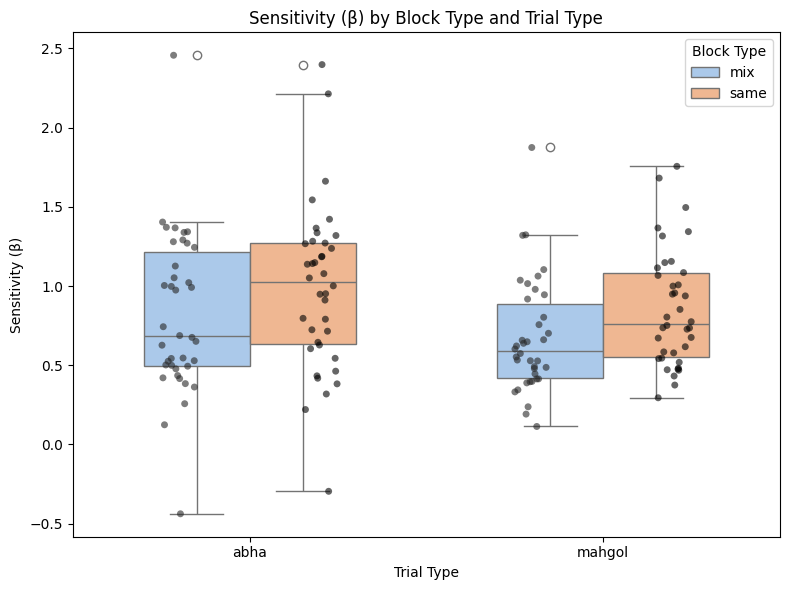

In [16]:
cols_to_melt = ['abha', 'mahgol']
mix_df_long = mix_df.melt(id_vars=['subject_id', 'sex'], value_vars=cols_to_melt,
                          var_name='trialType', value_name='beta')
mix_df_long['blockType'] = 'mix'
same_df_long = same_df.melt(id_vars=['subject_id', 'sex'], value_vars=cols_to_melt,
                            var_name='trialType', value_name='beta')
same_df_long['blockType'] = 'same'
combined_df = pd.concat([mix_df_long, same_df_long], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x='trialType', y='beta', hue='blockType',
            palette='pastel', dodge=True, width=0.6)
sns.stripplot(data=combined_df, x='trialType', y='beta', hue='blockType',
              dodge=True, jitter=True, color='black', alpha=0.6, size=5)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Block Type')
plt.title('Sensitivity (β) by Block Type and Trial Type')
plt.ylabel('Sensitivity (β)')
plt.xlabel('Trial Type')
plt.tight_layout()
plt.show()

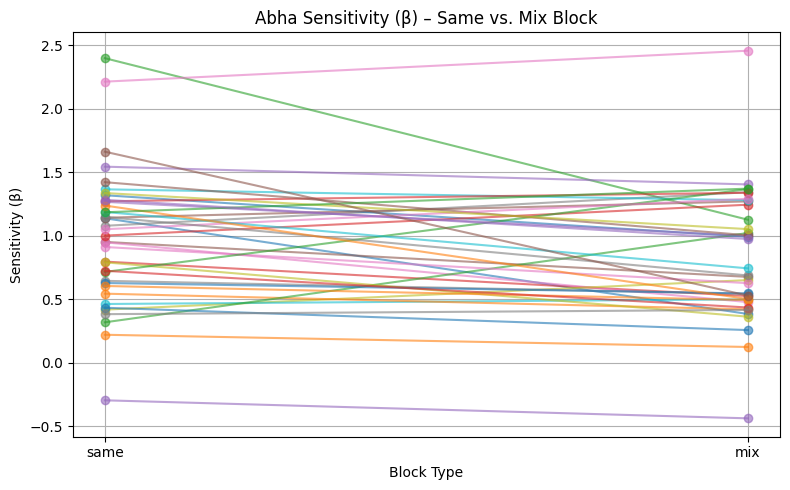

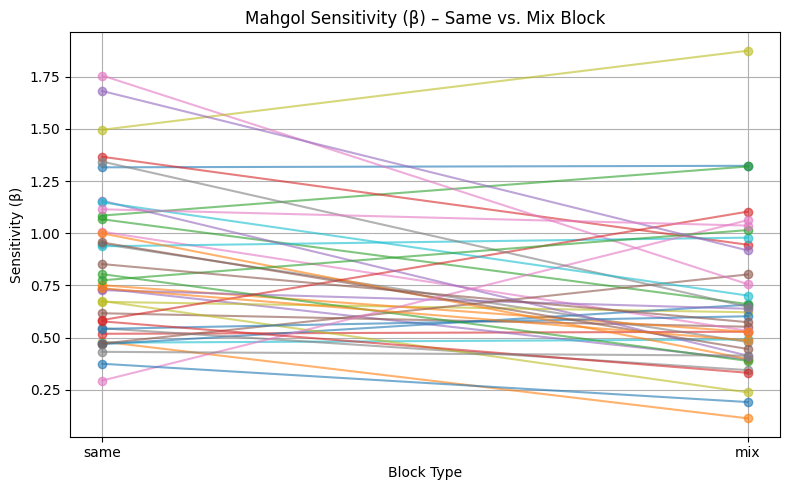

In [17]:
paired_df = same_df.merge(mix_df, on='subject_id', suffixes=('_same', '_mix'))
for trial in ['abha', 'mahgol']:
    plt.figure(figsize=(8, 5))
    for i, row in paired_df.iterrows():
        plt.plot(['same', 'mix'],
                 [row[f'{trial}_same'], row[f'{trial}_mix']],
                 marker='o', alpha=0.6, label=row['subject_id'] if i < 10 else "")
    plt.title(f'{trial.capitalize()} Sensitivity (β) – Same vs. Mix Block')
    plt.ylabel('Sensitivity (β)')
    plt.xlabel('Block Type')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
def compute_auc(data, pair):
    df = data[data['trialKeys'] == pair]
    if pair == 'AbHa':
        positive_class = 'Hasan'
        negative_class = 'Abbas'
    elif pair == 'MahGol':
        positive_class = 'Goli'
        negative_class = 'Mahnaz'
    else:
        raise ValueError("Invalid pair value.")
    df = df[df['srespChoice'].isin([positive_class, negative_class])]
    if df.empty:
        return np.nan
    y_true = (df['srespChoice'] == positive_class).astype(int)
    y_scores = df['levelFace'].values
    try:
        return roc_auc_score(y_true, y_scores)
    except Exception as e:
        print(f"[AUC ERROR] pair={pair}, subject skipped")
        print("Error:", e)
        return np.nan

In [19]:
betas_aucs = []
for i in range(1, len(sub_same)):
    subj_data = sub_same[i]
    subj_info = sub_info.iloc[i - 1]
    subj_row = {
        'subject_id': f"sub{i}",
        'sex': subj_info['sex']
    }
    for pair in ['AbHa', 'MahGol']:
        beta = fit_sigmoid_basic(subj_data, pair)
        auc = compute_auc(subj_data, pair)
        subj_row[f"{pair.lower()}_beta"] = beta
        subj_row[f"{pair.lower()}_auc"] = auc
    betas_aucs.append(subj_row)
same_df = pd.DataFrame(betas_aucs)

In [20]:
betas_aucs = []
for i in range(1, len(sub_mix)):
    subj_data = sub_mix[i]
    subj_info = sub_info.iloc[i - 1]
    subj_row = {
        'subject_id': f"sub{i}",
        'sex': subj_info['sex']
    }
    for pair in ['AbHa', 'MahGol']:
        beta = fit_sigmoid_basic(subj_data, pair)
        auc = compute_auc(subj_data, pair)
        subj_row[f"{pair.lower()}_beta"] = beta
        subj_row[f"{pair.lower()}_auc"] = auc
    betas_aucs.append(subj_row)
mix_df = pd.DataFrame(betas_aucs)

In [21]:
p_abha = wilcoxon(mix_df['abha_auc'], same_df['abha_auc'])
print("P value for abha", p_abha.pvalue)
p_mahgol = wilcoxon(mix_df['mahgol_auc'], same_df['mahgol_auc'])
print("P value for mahgol", p_mahgol.pvalue)

P value for abha 0.0011006118584191427
P value for mahgol 0.1364683882711688


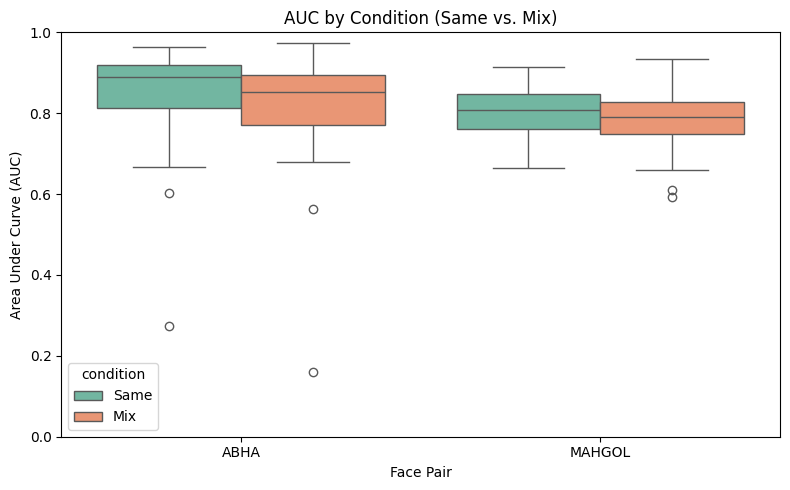

In [22]:
same_df['condition'] = 'Same'
mix_df['condition'] = 'Mix'
combined_df = pd.concat([same_df, mix_df], ignore_index=True)
auc_long = pd.melt(
    combined_df,
    id_vars=['condition'],
    value_vars=['abha_auc', 'mahgol_auc'],
    var_name='pair',
    value_name='auc'
)
auc_long['pair'] = auc_long['pair'].str.replace('_auc', '').str.upper()
plt.figure(figsize=(8, 5))
sns.boxplot(data=auc_long, x='pair', y='auc', hue='condition', palette='Set2')
plt.title("AUC by Condition (Same vs. Mix)")
plt.ylabel("Area Under Curve (AUC)")
plt.xlabel("Face Pair")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()